In [1]:
import os
import sys
from glob import glob
from adjustText import adjust_text

os.chdir('..') if not os.getcwd().endswith('data') else None

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.pipeline_utils import *
from utils.general_utils import normalized_col, normalize_data
from scipy.stats import sem
from scipy.stats.stats import pearsonr, spearmanr, kendalltau, pointbiserialr
from matplotlib.patches import FancyBboxPatch
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
pipeline_path = f'{run_prefix}pipeline'
files = glob(f'{pipeline_path}/csv/merged/*.csv')
analyze_tweets_dir = f'{run_prefix}data/analyze_tweets'
os.makedirs(f'{analyze_tweets_dir}/csv', exist_ok=True)
os.makedirs(f'{analyze_tweets_dir}/figs', exist_ok=True)

Load BGT Data

In [4]:
bgt_data = pd.read_csv(f'{run_prefix}data/job_offer/jolt data/BGT Data.csv')
bgt_data['date'] = pd.to_datetime(bgt_data['date'])
bgt_data = bgt_data.set_index('date')

Get categories mapping

In [5]:
cat_map = bgt_data[['category', 'category_label']].drop_duplicates().set_index('category')

In [6]:
cat_map['category_label']

category
 1                                             Managers
 2                                        Professionals
 3              Technicians and associate professionals
 4                             Clerical support workers
 5                            Service and sales workers
 6    Skilled agricultural, forestry and fishery wor...
 7                     Craft and related trades workers
 8          Plant and machine operators, and assemblers
 9                               Elementary occupations
-1                                                Total
Name: category_label, dtype: object

In [7]:
state_twitter_jolt_monthly = pd.read_csv(f'{analyze_tweets_dir}/csv/state_twitter_jolt_monthly.csv', parse_dates=['date'])
dfs = []
for date, df in state_twitter_jolt_monthly.groupby('date'):
    df['Normalized'] = normalized_col(df, 'Twitter', 'JOLTS Job openings')
    df['Twitter Coverage'] = normalize_data(df['Twitter'])
    df['JOLTS Job openings Coverage'] = normalize_data(df['JOLTS Job openings'])
    dfs.append(df)
state_twitter_jolt_monthly = pd.concat(dfs).reset_index(drop=True)
state_twitter_jolt_monthly[['lat', 'lon']] = user_locations.loc[state_twitter_jolt_monthly['state']].reset_index()[['latitude', 'longitude']].astype(float)
state_twitter_jolt_monthly['date'] = state_twitter_jolt_monthly.date.dt.date
state_twitter_jolt_monthly['year'] = state_twitter_jolt_monthly['date'].apply(lambda x: str(x)[:4])

In [8]:
state_twitter_jolt = state_twitter_jolt_monthly[['Twitter', 'JOLTS Job openings', 'state', 'Twitter Coverage', 'JOLTS Job openings Coverage']].groupby('state').agg([np.mean, np.std, sem]).reset_index()\
    .sort_values(('Twitter Coverage', 'mean')).reset_index(drop=True)

In [9]:
import statsmodels.api as sm
x = state_twitter_jolt['Twitter Coverage']['mean']
y = state_twitter_jolt['JOLTS Job openings Coverage']['mean']

# fit a linear curve an estimate its y-values and their error.
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
predictions = model.get_prediction(X)
ci = predictions.summary_frame(alpha=0.05)

In [10]:
def plot_lines_and_fill(ax, x, ymid, y_upp1_5=None, y_down1_5=None, y_upp2=None, y_down2=None, fill_between=False):
    ax.plot(x, ymid, 'grey', linestyle='--')
    if y_upp1_5 is not None:
        ax.plot(x, y_upp1_5, 'grey', linestyle='--', linewidth=1)
    if y_down1_5 is not None:
        ax.plot(x, y_down1_5, 'grey', linestyle='--', linewidth=1)
    if y_upp2 is not None:
        ax.plot(x, y_upp2, 'grey', linestyle='--', linewidth=0.8)
        if fill_between:
            ax.fill_between(x, y_upp2, y_upp1_5, color='gray', alpha=0.1)
    if y_down2 is not None:
        ax.plot(x, y_down2, 'grey', linestyle='--', linewidth=0.8)
        if fill_between:
            ax.fill_between(x, y_down2, y_down1_5, color='gray', alpha=0.1)
    if fill_between and y_upp1_5 is not None and y_down1_5 is not None:
        ax.fill_between(x, y_upp1_5, y_down1_5, color='gray', alpha=0.3)

In [11]:
state_code_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv', usecols=['code', 'state'])
state_code_df = pd.concat([state_code_df, pd.DataFrame({'state': 'District of Columbia', 'code': 'DC'}, index=[0])])
state_code_df = state_code_df.set_index('state')

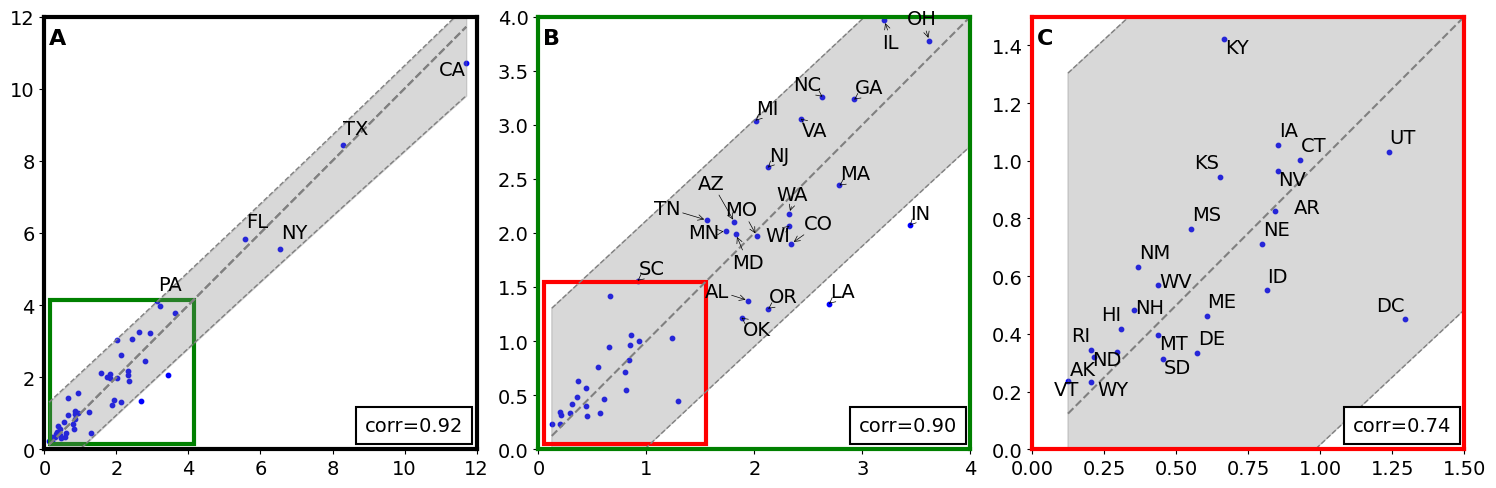

In [12]:
# create subplots
# x = np.arange(0, 51, 1)
xmid = np.arange(0, 51, 1)
y_upp1_5 = x*1.5
y_down1_5 = x*(1/1.5)
y_upp2 = x*2
y_down2 = x*0.5
tick_fontsize = 14
label_fontsize = 14
abc_tag_fontsize = 16
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
bbox_props = dict(boxstyle='square,pad=0.45', facecolor='white', edgecolor='black', linewidth=1.5)
# Data for ax1
state_name = state_code_df.loc[state_twitter_jolt['state']]['code']
twitter_percentage = state_twitter_jolt['Twitter Coverage']['mean']
truth_percentage = state_twitter_jolt['JOLTS Job openings Coverage']['mean']
twitter_error = state_twitter_jolt['Twitter Coverage']['std']
truth_error = state_twitter_jolt['JOLTS Job openings Coverage']['std']
max_value = math.ceil(max(twitter_percentage.max(), truth_percentage.max()))
# Plot ax1
ax1.scatter(twitter_percentage, truth_percentage, color='blue', s=10)
# Annotate ax1
texts = []
for i, state in enumerate(state_name):
    if twitter_percentage[i] >= 4 or truth_percentage[i] >= 4:
        texts.append(ax1.text(twitter_percentage[i], truth_percentage[i]+0.15, state, fontsize=label_fontsize, ha='center'))
adjust_text(texts, ax=ax1)
# Plot lines and boundries
ax1.plot(x, x, 'grey', linestyle='--')
# Calculate Correlation all
corr_dict = {'pearsonr': [], 'spearmanr': [], 'kendalltau': [], 'pointbiserialr': []}
corr_dict['pearsonr'].append(pearsonr(twitter_percentage, truth_percentage))
corr_dict['spearmanr'].append([x for x in spearmanr(twitter_percentage, truth_percentage)])
corr_dict['kendalltau'].append([x for x in kendalltau(twitter_percentage, truth_percentage)])
corr_dict['pointbiserialr'].append([x for x in pointbiserialr(twitter_percentage, truth_percentage)])
# set axis labels
corr, p_value = spearmanr(twitter_percentage, truth_percentage)
ax1.text(0.03, 0.95, f'A', ha='center', va='center', transform=ax1.transAxes, fontsize=abc_tag_fontsize, fontweight='bold')
ax1.text(0.855, 0.055, f'corr={corr:.2f}', ha='center', va='center', transform=ax1.transAxes, fontsize=label_fontsize, bbox=bbox_props)
# add boundary box
bbox = FancyBboxPatch((0.15, 0.15), 4, 4, boxstyle='square,pad=0', fc='none', ec='green', linewidth=3)
ax1.add_patch(bbox)
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 12)
# color the spines
ax1.spines[:].set_color('black')
ax1.spines[:].set_linewidth(3)
plot_lines_and_fill(ax1, x, x, ci['obs_ci_lower'], ci['obs_ci_upper'], fill_between=True)
# Increase tick size for ax1
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=tick_fontsize)
# ax2 data
sample = state_twitter_jolt[(state_twitter_jolt['Twitter Coverage']['mean'] <= 4) & (state_twitter_jolt['JOLTS Job openings Coverage']['mean'] <= 4)].reset_index(drop=True)
state_name = state_code_df.loc[sample['state']]['code']
twitter_percentage = sample['Twitter Coverage']['mean']
truth_percentage = sample['JOLTS Job openings Coverage']['mean']
twitter_error = sample['Twitter Coverage']['std']
truth_error = sample['JOLTS Job openings Coverage']['std']
ax2.scatter(twitter_percentage, truth_percentage, color='blue', s=10)
texts = []
for i, state in enumerate(state_name):
    if twitter_percentage[i] >= 1.5 or truth_percentage[i] >= 1.5:
        texts.append(ax2.text(twitter_percentage[i], truth_percentage[i], state, fontsize=label_fontsize, ha='center'))
adjust_text(texts, ax=ax2, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
ax2.set_xlim(0, 4)
ax2.set_ylim(0, 4)
ax2.spines[:].set_color('green')
ax2.spines[:].set_linewidth(3)
plot_lines_and_fill(ax2, x, x, ci['obs_ci_lower'], ci['obs_ci_upper'], fill_between=True)
# plot_lines_and_fill(ax2, x, ymid, y_upp1_5, y_down1_5, y_upp2, y_down2, fill_between=True)
bbox = FancyBboxPatch((0.05, 0.05), 1.5, 1.5, boxstyle='square,pad=0', fc='none', ec='red', linewidth=3)
ax2.add_patch(bbox)
corr_dict['pearsonr'].append(pearsonr(twitter_percentage, truth_percentage))
corr_dict['spearmanr'].append([x for x in spearmanr(twitter_percentage, truth_percentage)])
corr_dict['kendalltau'].append([x for x in kendalltau(twitter_percentage, truth_percentage)])
corr_dict['pointbiserialr'].append([x for x in pointbiserialr(twitter_percentage, truth_percentage)])
corr, p_value = spearmanr(twitter_percentage, truth_percentage)
ax2.text(0.03, 0.95, f'B', ha='center', va='center', transform=ax2.transAxes, fontsize=abc_tag_fontsize, fontweight='bold')
ax2.text(0.855, 0.055, f'corr={corr:.2f}', ha='center', va='center', transform=ax2.transAxes, fontsize=label_fontsize, bbox=bbox_props)
# Increase tick size for ax2
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=tick_fontsize)
# ax3 data
sample = state_twitter_jolt[(state_twitter_jolt['Twitter Coverage']['mean'] <= 1.5) & (state_twitter_jolt['JOLTS Job openings Coverage']['mean'] <= 1.5)].reset_index(drop=True)
state_name = state_code_df.loc[sample['state']]['code']
twitter_percentage = sample['Twitter Coverage']['mean']
truth_percentage = sample['JOLTS Job openings Coverage']['mean']
twitter_error = sample['Twitter Coverage']['std']
truth_error = sample['JOLTS Job openings Coverage']['std']
ax3.scatter(twitter_percentage, truth_percentage, color='blue', s=10)
texts = []
for i, state in enumerate(state_name):
    texts.append(ax3.text(twitter_percentage[i], truth_percentage[i]+0.01, state, fontsize=label_fontsize, ha='center'))
adjust_text(texts, ax=ax3)
ax3.set_xlim(0, 1.5)
ax3.set_ylim(0, 1.5)
ax3.spines[:].set_color('red')
ax3.spines[:].set_linewidth(3)
plot_lines_and_fill(ax3, x, x, ci['obs_ci_lower'], ci['obs_ci_upper'], fill_between=True)
# plot_lines_and_fill(ax3, x, ymid, y_upp1_5, y_down1_5, y_upp2, y_down2, fill_between=True)
corr_dict['pearsonr'].append(pearsonr(twitter_percentage, truth_percentage))
corr_dict['spearmanr'].append([x for x in spearmanr(twitter_percentage, truth_percentage)])
corr_dict['kendalltau'].append([x for x in kendalltau(twitter_percentage, truth_percentage)])
corr_dict['pointbiserialr'].append([x for x in pointbiserialr(twitter_percentage, truth_percentage)])
corr, p_value = spearmanr(twitter_percentage, truth_percentage)
ax3.text(0.03, 0.95, f'C', ha='center', va='center', transform=ax3.transAxes, fontsize=abc_tag_fontsize, fontweight='bold')
ax3.text(0.855, 0.055, f'corr={corr:.2f}', ha='center', va='center', transform=ax3.transAxes, fontsize=label_fontsize, bbox=bbox_props)
# Increase tick size for ax3
ax3.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=tick_fontsize)
plt.tight_layout()
plt.savefig(f'{analyze_tweets_dir}/figs/state_twitter_jolt_monthly_state_normalized_line', dpi=400)
plt.savefig(f'{analyze_tweets_dir}/figs/state_twitter_jolt_monthly_state_normalized_line.pdf', format='pdf')
plt.show()

In [13]:
us_twitter_bgt_emp_yearly = pd.read_csv(f'{analyze_tweets_dir}/csv/us_twitter_bgt_emp_yearly.csv', parse_dates=['date'])
us_twitter_bgt_emp_yearly['year'] = us_twitter_bgt_emp_yearly.date.dt.year
us_twitter_bgt_emp_yearly = us_twitter_bgt_emp_yearly[us_twitter_bgt_emp_yearly['year'] >= 2017]
corr_dict = {'category': [], 'pearsonr': [], 'spearmanr': [], 'kendalltau': [], 'pointbiserialr': []}
for cat, gdf in tqdm(us_twitter_bgt_emp_yearly[['Category Label', 'Twitter normalized by year', 'BGT normalized by year']].groupby('Category Label')):
    corr_dict['category'].append(cat)
    corr_dict['pearsonr'].append(pearsonr(gdf['Twitter normalized by year'], gdf['BGT normalized by year']))
    corr_dict['spearmanr'].append([x for x in spearmanr(gdf['Twitter normalized by year'], gdf['BGT normalized by year'])])
    corr_dict['kendalltau'].append([x for x in kendalltau(gdf['Twitter normalized by year'], gdf['BGT normalized by year'])])
    corr_dict['pointbiserialr'].append([x for x in pointbiserialr(gdf['Twitter normalized by year'], gdf['BGT normalized by year'])])
corrs = pd.DataFrame(corr_dict).explode(['pearsonr', 'spearmanr', 'kendalltau', 'pointbiserialr'])
corrs.index = ['Correlation', 'p-value'] * 9
corrs = corrs.reset_index().rename({'index': 'stat'}, axis=1)
corrs = corrs.pivot_table(index='category', columns='stat')

100%|██████████| 9/9 [00:00<00:00, 429.69it/s]


In [14]:
corr_method = 'pearsonr'

In [15]:
us_twitter_bgt_emp_yearly = pd.read_csv(f'{analyze_tweets_dir}/csv/us_twitter_bgt_emp_yearly.csv', parse_dates=['date'])
us_twitter_bgt_emp_yearly['year'] = us_twitter_bgt_emp_yearly.date.dt.year
us_twitter_bgt_emp_yearly = us_twitter_bgt_emp_yearly[us_twitter_bgt_emp_yearly['year'] >= 2015]

In [16]:
us_twitter_bgt_emp_yearly = us_twitter_bgt_emp_yearly[['year', 'Category Label', 'category', 'Twitter normalized by year', 'BGT normalized by year']].melt(['year', 'Category Label', 'category'], var_name='Source')

In [17]:
us_twitter_bgt_emp_yearly = us_twitter_bgt_emp_yearly.sort_values(['year', 'Category Label']).reset_index(drop=True)
us_twitter_bgt_emp_yearly[['corr', 'p-value']] = us_twitter_bgt_emp_yearly['Category Label'].apply(lambda cl: corrs.loc[cl].loc[corr_method])

In [18]:
cat_map.category_label

category
 1                                             Managers
 2                                        Professionals
 3              Technicians and associate professionals
 4                             Clerical support workers
 5                            Service and sales workers
 6    Skilled agricultural, forestry and fishery wor...
 7                     Craft and related trades workers
 8          Plant and machine operators, and assemblers
 9                               Elementary occupations
-1                                                Total
Name: category_label, dtype: object

In [19]:
corr_pos = [(0.88, 0.83), (0.88, 0.83), (0.88, 0.15), (0.88, 0.83), (0.88, 0.83), (0.88, 0.83), (0.88,  0.83), (0.88,  0.83), (0.88, 0.15)]
leg_loc = ["lower left", "lower left", "upper left", "upper left", "upper left", "upper left", "upper left", "lower left", "upper left"]

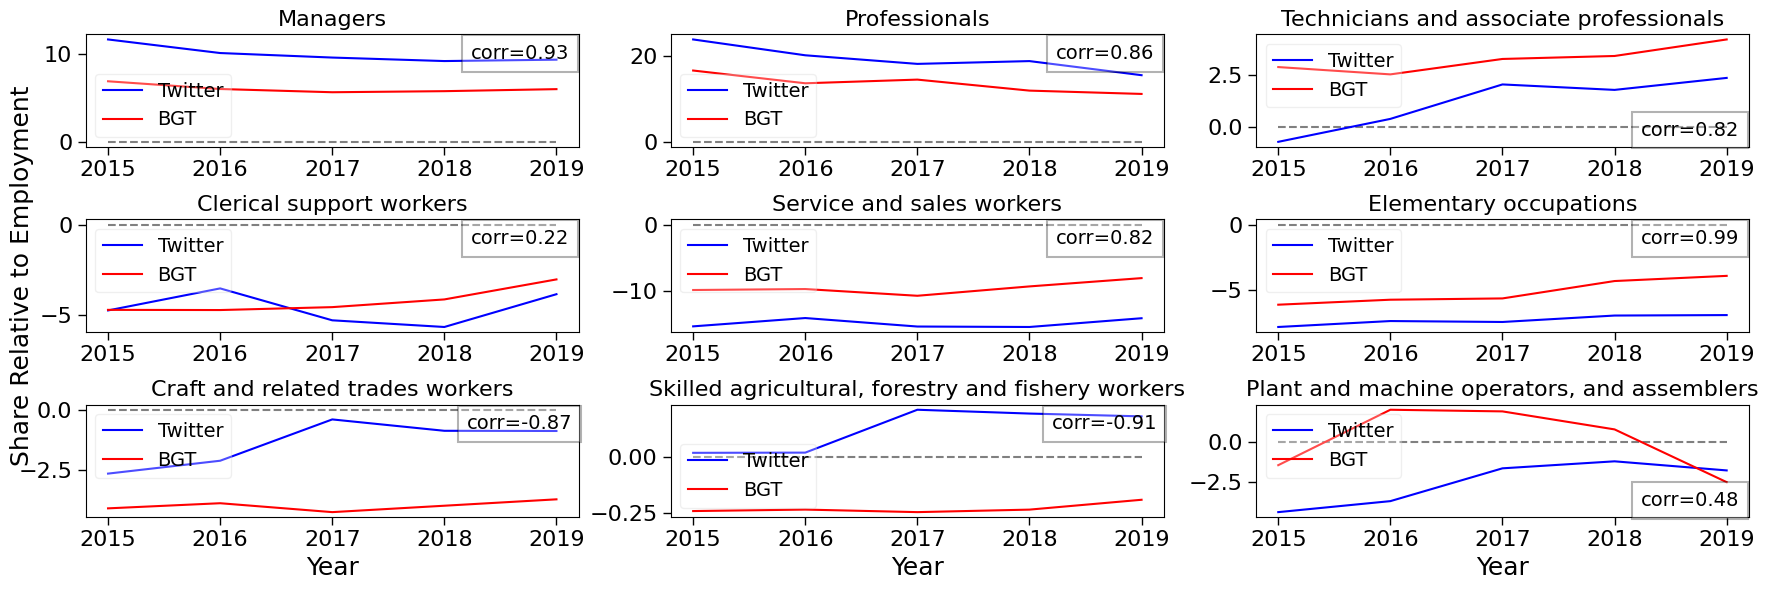

In [20]:
occupations = us_twitter_bgt_emp_yearly['Category Label'].unique()
alpha = 0.3
bbox_props = dict(boxstyle='square,pad=0.45', facecolor='white', edgecolor='black', linewidth=1.5, alpha=alpha)
fig, ((x1, x2, x3), (x4, x5, x6), (x7, x8, x9)) = plt.subplots(3, 3, figsize=(18, 6))
tick_fontsize = 16
label_fontsize = 14
title_fontsize = 16
axis_fontsize = 18
categories = [
    "Managers",
    "Professionals",
    "Technicians and associate professionals",
    "Clerical support workers",
    "Service and sales workers",
    "Elementary occupations",
    "Craft and related trades workers",
    "Skilled agricultural, forestry and fishery workers",
    "Plant and machine operators, and assemblers"
]
for idx, category in enumerate(list(categories), 1):
     data = us_twitter_bgt_emp_yearly[us_twitter_bgt_emp_yearly['Category Label'] == category]
     years = [str(int(y)) for y in data.year.unique()]
     twitter = data[data['Source'] == 'Twitter normalized by year'].value
     bgt = data[data['Source'] == 'BGT normalized by year'].value
     axis = locals()[f'x{idx}']
     axis.text(*corr_pos[idx-1], f"corr={corrs[idx-1]}", ha='center', va='center', transform=axis.transAxes, fontsize=label_fontsize, bbox=bbox_props)
     axis.plot(years, [0] * len(years), 'grey', linestyle='--')
     axis.plot(years, twitter, color='blue', label='Twitter')
     axis.plot(years, bgt, color='red', label='BGT')
     if idx > 6:
         axis.set_xlabel('Year', fontsize=axis_fontsize)
     if idx == 4:
         axis.set_ylabel('Share Relative to Employment', fontsize=axis_fontsize)
     axis.set_title(category, fontsize=title_fontsize)
     axis.tick_params(axis='both', which='major', labelsize=tick_fontsize, length=6, width=1)
     axis.tick_params(axis='both', which='minor', labelsize=tick_fontsize, length=6, width=1)
     axis.legend(fontsize=label_fontsize, loc=leg_loc[idx-1], framealpha=alpha)

plt.tight_layout()
plt.savefig(f'{analyze_tweets_dir}/figs/us_twitter_bgt_emp_yearly_year_line', dpi=400)
plt.savefig(f'{analyze_tweets_dir}/figs/us_twitter_bgt_emp_yearly_year_line.pdf', format='pdf')
plt.show()